# Do hot naked selfies get the most likes on Instagram?
## A case study
My favorite instagrammer once said something along the lines of "I have thousands of professional modeling photos, but all you guys want to see is mirror selfies of me in my underwear."

Is this true? Would the average viewer prefer a candid lingerie photo over a glitzy shot on set with hair, makeup, wardrobe, etc? I decided to find out.

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, linregress, kruskal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
from InstagramAPI import InstagramAPI

### Instagram API
Shout out to [LevPasha](https://github.com/LevPasha/Instagram-API-python) on GitHub for writing these APIs. He did all the hard work.

In [2]:
api = InstagramAPI('username', 'password')

Login to my account.

In [3]:
api.login()

Request return 405 error!
{'message': '', 'status': 'fail'}
Login success!



True

### Instagrammer Selection
Obviously to do this in real depth would require pulling data from at least hundreds of users. That way you can control for differences between a given user's following and with more data points the trends found tend to be more extrapalatable. For example, different cultures have different beauty standards. People will follow different versions of what they consider attractive on Instagram and this will ripple over into which photos get the most likes and comments. Thus only looking at a single user won't necessarily provide insight into greater trends. However, I don't have that kind of free time. 

My crush du jour is [Teddy Quinlivan](https://www.instagram.com/teddy_quinlivan/), so we'll be using her account as the data set. She has over 1000 photos ranging from walking the Louis Vuitton runway to pulling lewks at China Chalet to random art finds. There's a lot of hot content on her account, but there's also a plethora of content that might disinterest the typical male [@emrata](https://www.instagram.com/emrata/) follower. Hopefully this will give us enough variation to see if the hot selfies really do get all the likes.

Using the API we'll search for her account by handle and find her account number.

In [4]:
api.searchUsername('teddy_quinlivan')
api.LastJson

{'user': {'pk': 1904001441,
  'username': 'teddy_quinlivan',
  'full_name': 'Theodora Quinlivan',
  'is_private': False,
  'profile_pic_url': 'https://scontent-lga3-1.cdninstagram.com/v/t51.2885-19/s150x150/47695016_2286338751596772_7740193201025187840_n.jpg?_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_ohc=MTnYvmAYn6AAX8yN19a&oh=bb2a4a7887109b66f738e0a5545acc98&oe=5E928187',
  'profile_pic_id': '1953616360206528395_1904001441',
  'is_verified': True,
  'has_anonymous_profile_picture': False,
  'media_count': 1178,
  'geo_media_count': 0,
  'follower_count': 122596,
  'following_count': 769,
  'following_tag_count': 0,
  'biography': 'Live Fast, Die Last \nüë†üé±üééüî™üåπüîÆ\nVision - Los Angeles\nSelect - London\nPremium - Paris \nMonster - Milan\nSupreme - NYC',
  'biography_with_entities': {'raw_text': 'Live Fast, Die Last \nüë†üé±üééüî™üåπüîÆ\nVision - Los Angeles\nSelect - London\nPremium - Paris \nMonster - Milan\nSupreme - NYC',
   'entities': []},
  'external_url': 'h

### Scraping the data
Now that we've found her account number we can get her entire feed and all meta data with a single command.

In [49]:
user_data = api.getTotalUserFeed('1904001441')

From the raw data I'd like to collect 5 features: the timestamp, number of likes, number of comments, the caption, and location.

The API grabs the data with the most recent post as 0, so we'll reverse iterate through it so we can save the photos numbered from 0 being the first photo she ever posted to n being the most recent. I've placed all the feature grabbing lines in try/excepts because I found some photos had comments disabled or no location data as the feature was not part of the original app. For posts without this data 0/nulls were inserted into the data set.

I made a TQ_Data folder on my desktop which will hold all of her photos numbered by post and a csv containing the metadata. The index of the csv will match the photo number.

In [50]:
columns = ['timestamp', 'likes', 'comments', 'caption', 'location']
ar = np.zeros((len(user_data), len(columns)))
df = pd.DataFrame(ar, columns=columns)
print(len(user_data))
for i in range(len(user_data) - 1, -1, -1): # loop backwards so first photo is 0 and most recent is n
    try:
        time = user_data[i]['taken_at']
    except:
        time = ''
    try:
        likes = user_data[i]['like_count']
    except:
        likes = 0
    try:
        comments = user_data[i]['comment_count'] # comments may be disabled
    except:
        comments = 0
    try:
        caption = user_data[i]['caption']['text']
    except:
        caption = ''
    try:
        location = user_data[i]['location']['name'] # location wasn't always a feature
    except:
        location = ''
        
    df.loc[len(user_data) - i - 1, :] = [time, likes, comments, caption, location]

#     try:
#         link = TQ_data[i]['image_versions2']['candidates'][0]['url']
#         urllib.request.urlretrieve(link, f'~/Desktop/TQ_Data/TQ_{len(TQ_data) - i - 1}.jpg')
#     except:
#         try:
#             link = TQ_data[i]['carousel_media'][1]['image_versions2']['candidates'][0]['url']
#             urllib.request.urlretrieve(link, f'~/Desktop/TQ_Data/TQ_{len(TQ_data) - i - 1}.jpg')
#         except:
#             pass
        
df.to_csv('~/Desktop/TQ_Data/TQ_Data11.csv')

1179


## Data Labeling
The funny thing about machine learning is that the intial steps are pretty human intensive. Before computers and data scientists can do anything with image data the data has to be labeled. Humans know cats vs dogs by sight, but a computer has to relate it to the 3 letter word c-a-t.

That means I went through over 1000 photo manually labeling features: rating, showing, taken_by.

Let's break this down because this is the most controversial/important part. Classifying images in the context of this study is subjective, so I made the decision to add a couple new features to help define each image. That being said, the labels used were predominantly a product of the model chosen. Given this account's content there was no need to create labels such as gym pic or booty pic as Teddy is neither a "fit-chick" nor bikini model. This once again reduces the likelihood that trends found are reflected in the greater model/influencer Instamgram community. At any rate, these are the features and associated labels defined and I already regret not including thirst trap.

**Rating**: a measure of attractiveness
* Casual: a photo of the user in a normal day-to-day context
* Glamour Shot: a photo that evidences prior setup (eg. a fashion show or something clearly not candid)
* Hot: a photo of the user clothed where it seems a more than usual effort was made to look attractive 
* Not Self: a photo of anything other than the user (may include other people, objects, drawings, etc)
* Nude: a photo where the user is naked
* Scantily Clad: a photo where the user is wearing highly revealing clothing

**Showing**: a measure how much of the user's body is shown
* Body: a photo containing either the entirety or majority of the user's body
* Bust: a photo of the user from the bust up
* Head: a photo of the user's head
* null: photos not of the user are marked null

**Taken By**: tagging the photographer
* Amateur: a photo taken by any non-professional
* Professional: a photo taken by what appears to be a career photographer
* Self: a photo taken by the user - a selfie in the modern parlance
* null: photos not of the user are marked null

### Subjectivity 
The choosing of these features and each one of their facets is a highly subjective matter. One could argue that just by the items chosen I have already skewed that data and introduced a bias. Probably. I acknowledge there are better ways to do this, for example conducting preliminary studies to see how other people categorize the images or having multiple people label the photos to control for personal preferences.

I'm doing this for fun, so doing all of that would have been a lot more than I bargained for. It just means that the results in this study are dependant on the labels used and the account chosen. Whether the conclusions in here map over to the rest of Instagram... who knows. Maybe another day I or another may take this up again and conduct it with more scientific rigor. 

### Examples
Before going on, it will be helpful to see an example of each of the categories defined above. First let's make a function to easily plot images by their number.

In [40]:
def plot_img(num):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(mpimg.imread(f'/Users/XXI/Desktop/TQ_Data/TQ_{num}.jpg'));

### casual, head, self
This casual selfie with a friend only includes her head. 

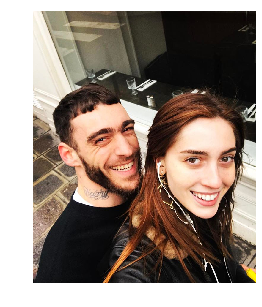

In [8]:
plot_img(477)

### glamour shot, body, professional
The fashion brand name across the photo makes it obvious that this photo has been staged and was shot by a professional. We can see Teddy's entire body here.

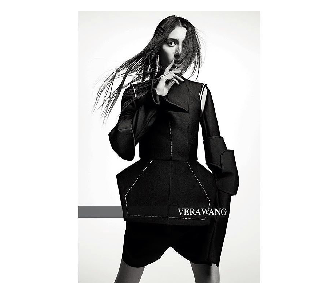

In [9]:
plot_img(893)

### glamour shot, body, amateur
Here Teddy is clearly wearing a couture ensemble and her whole body is visible. However, this photo is not on a set and likely shot by a friend.

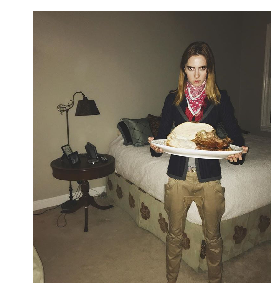

In [10]:
plot_img(410)

### hot, bust, amateur
Between the makeup, jewely, and spaghetti strap top I think it's safe to say she didn't roll out of bed like this. The image is framed from slightly below the shoulders and up and most likely not taken by a professional.

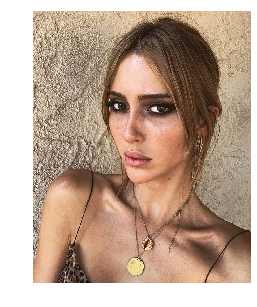

In [11]:
plot_img(1079)

### scantily clad, body, amateur
In this photo there is no guesswork. Just read the caption:

"Ok so last night I was invited to this **messy lingerie themed** Halloween party, and of course I'm so down because I'm basically a hooker and an attention whore so this party was right up my ally. I didn't end up having any fun cuz they make you sign an NDA at the door and it was a pussy fest (there were only girls there). Not only that, but I'm so used to being the only tall hot slut at parties, and this particular party was filled with so many hot girls who had way better bodies than me, so I didn't even stand out or feel special, I was just 1 in 1000 sexy hot slutty girls. I tried to take this picture in the bathroom to discreetly capture my glam and I would like to **thank the real MVP [@giselleadorabrune](https://www.instagram.com/giselleadorabrune/) for Kneeling in a pile of toilette paper to take this picture** of me. Halloween parties are a overrated scam, next year I'm going as a ghost."

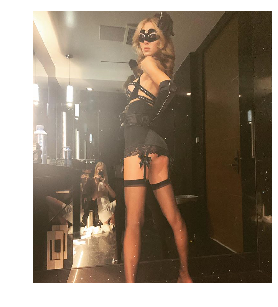

In [12]:
plot_img(1125)

### nude, bust, amateur
This is about as naked as you can get on Instagram.

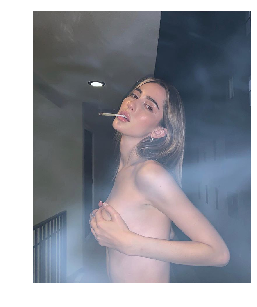

In [13]:
plot_img(1137)

### not self, null, null
For this post Teddy used a meme for the image. 

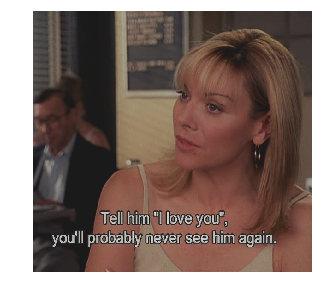

In [14]:
plot_img(1151)

### All the permutations
These photos show all the possible labels in each catgory, but don't even begin to capture all the possible permutations between rating, showing, and taken by.

## Analysis
### Data: import, clean, augment

In [18]:
data = pd.read_csv('/Users/XXI/Desktop/TQ_Data/TQ_Data.csv', header=0, low_memory=False)
display(data.head(3))

photo_num   timestamp  likes  comments  \
0       1179  1584212460   1475        30   
1       1178  1584051102   4057        82   
2       1177  1583775936  12418       220   

                                             caption                 location  \
0                     Cough on me bitch. I dare you.  Los Angeles, California   
1                                          Lil Teddy                      NaN   
2  Coverstory for El Pa√≠s Semanal shot by Gorka P...                    Spain   

         rating showing      taken_by  
0  glamour shot    body  professional  
1        casual    body       amateur  
2  glamour shot    body  professional

dsfsd 

In [19]:
data.fillna('null', inplace=True)
print(data['rating'].unique())
print(data['showing'].unique())
print(data['taken_by'].unique())

['glamour shot' 'casual' 'not self' 'hot' 'nude' 'scantily clad' '0']
['body' 'null' 'bust' 'head']
['professional' 'amateur' 'null' 'self']


dsfdsf

In [20]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date
data['year'] = data['datetime'].dt.year.astype(int)
data['day'] = data['datetime'].dt.dayofweek.astype(int)
data['hour'] = data['datetime'].dt.strftime('%H').astype(int)
display(data.head(3))

photo_num   timestamp  likes  comments  \
0       1179  1584212460   1475        30   
1       1178  1584051102   4057        82   
2       1177  1583775936  12418       220   

                                             caption                 location  \
0                     Cough on me bitch. I dare you.  Los Angeles, California   
1                                          Lil Teddy                     null   
2  Coverstory for El Pa√≠s Semanal shot by Gorka P...                    Spain   

         rating showing      taken_by            datetime        date  year  \
0  glamour shot    body  professional 2020-03-14 19:01:00  2020-03-14  2020   
1        casual    body       amateur 2020-03-12 22:11:42  2020-03-12  2020   
2  glamour shot    body  professional 2020-03-09 17:45:36  2020-03-09  2020   

   day  hour  
0    5    19  
1    3    22  
2    0    17

### First look
The plot below shows likes and comments on photos over time. What's interesting to notice is the large spread in likes on the more recent photos. While some photos begin to amass over 10k likes regularly, others still fail to get over 2.5k. Not all photos necessarily got more likes as her following grew.

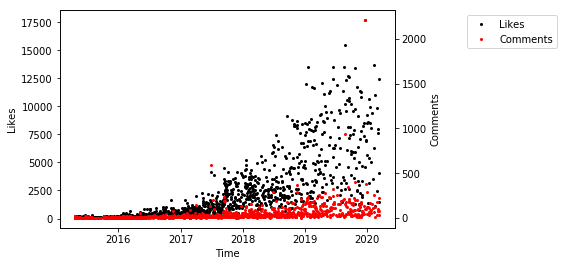

In [21]:
fig, ax = plt.subplots()
plt1 = ax.plot_date(data['date'], data['likes'], color='k', markersize=2)
ax0 = ax.twinx()
plt2 = ax0.plot_date(data['date'], data['comments'], color='r', markersize=2)
ax.set_xlabel('Time')
ax.set_ylabel('Likes')
ax0.set_ylabel('Comments')
plts = plt1 + plt2
labels = ['Likes', 'Comments']
ax.legend(plts, labels, bbox_to_anchor=[1.5, 0, 0, 1]);

### Detrend
When someone joins Instagram they have 0 followers. The increase in likes over time is directly correlated to the number of followers she's gained over the years. Unfortunately, it's not possible get the number of followers in time, so we can't detrend it directly based on follower count. To truly compare likes in one photo to the next, especially over time we need to detrend the data another way. Let's first take the natural log of the likes and comments.

In [22]:
data0 = data.copy()
data0['likes'] = np.log(data0['likes'] + 1)
data0['comments'] = np.log(data0['comments'] + 1)

In the plot below we'll see that the data is already a lot neater and a more evident trend appears. So let's go ahead and make a linear regression of the likes and comments.

In [23]:
linreg_likes = linregress(data0['timestamp'], data0['likes'])
linreg_comments = linregress(data0['timestamp'], data0['comments'])
print(linreg_likes)
print(linreg_comments)

LinregressResult(slope=3.079277243153127e-08, intercept=-39.37522174168657, rvalue=0.9148962653960491, pvalue=0.0, stderr=3.958687573071624e-10)
LinregressResult(slope=2.4610779773725075e-08, intercept=-34.08450752455959, rvalue=0.7764118846835785, pvalue=1.916266112341009e-238, stderr=5.820452468501666e-10)


Plotting the data now with the linear regressions it seems there's a pretty good fit. Note that the streaking pattern in comments on the lower left is caused by photos receiving few comments early in her account history. If photos are only getting 1-10 comments the spread is quite small relative to photos getting 10-100 comments, hence why the comments scatter plot starts off streaked and then becomes more scattered.

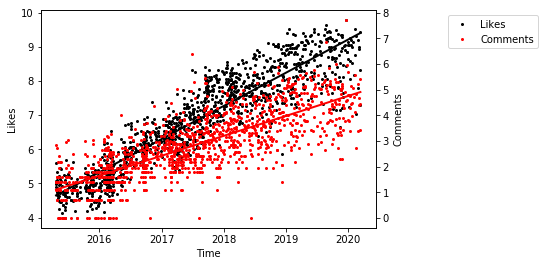

In [24]:
fig, ax = plt.subplots()
plt1 = ax.plot_date(data0['date'], data0['likes'], color='k', markersize=2)
ax.plot_date(data0['date'], data0['timestamp']*linreg_likes[0] + linreg_likes[1], color='k', linestyle='-', linewidth=2, alpha=1, marker=None)
ax0 = ax.twinx()
plt2 = ax0.plot_date(data0['date'], data0['comments'], color='r', markersize=2)
ax0.plot_date(data0['date'], data0['timestamp']*linreg_comments[0] + linreg_comments[1], color='r', linestyle='-', linewidth=2, alpha=1, marker=None)
ax.set_xlabel('Time')
ax.set_ylabel('Likes')
ax0.set_ylabel('Comments')
plts = plt1 + plt2
labels = ['Likes', 'Comments']
ax.legend(plts, labels, bbox_to_anchor=[1.5, 0, 0, 1]);

Now let's subtract out the regression and normalize the values between 0 and 1. This will fully detrend the data a give an easy to use metric: normalized likes and comments.

In [25]:
data0['likes'] -= data0['timestamp']*linreg_likes[0] + linreg_likes[1]
data0['comments'] -= data0['timestamp']*linreg_comments[0] + linreg_comments[1]

data0['likes'] = (data0['likes'] - min(data0['likes']))/(max(data0['likes']) - min(data0['likes']))
data0['comments'] = (data0['comments'] - min(data0['comments']))/(max(data0['comments']) - min(data0['comments']))

Finally we have a fully detrended and normalized data set. These values will make it possible to compare likes and comments over time from one image to another.

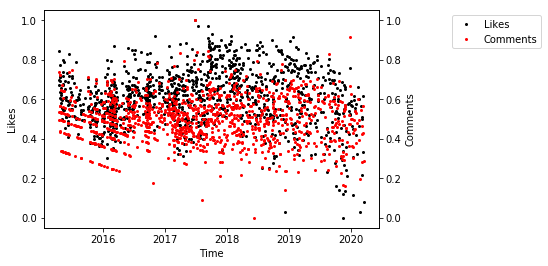

In [26]:
fig, ax = plt.subplots()
plt1 = ax.plot_date(data0['date'], data0['likes'], color='k', markersize=2)
ax0 = ax.twinx()
plt2 = ax0.plot_date(data0['date'], data0['comments'], color='r', markersize=2)
ax.set_xlabel('Time')
ax.set_ylabel('Likes')
ax0.set_ylabel('Comments')
plts = plt1 + plt2
labels = ['Likes', 'Comments']
ax.legend(plts, labels, bbox_to_anchor=[1.5, 0, 0, 1]);

### So do hot naked selfies get the most likes?
Yes, but not really. For each of the three main features there are plots below of the number of photos for each label in the feature and the number of normalized likes per photo for the label. Photos rated as nude, of the bust, taken by the user receive the most likes as independant features . However, for photos rated as glamour shots bring in ** **0.83** ** normalized likes for every normalized like a nude photo gets. Even casual photos  get more normalized likes than that. Photos labeled as not self are the real losers bringing in only 0.6** ** normalized likes.

In the other categories we see a similar pattern among the labels. The spread between photos of the head, bust, and body isn't that large, but all three of those values differ a lot from the value for the label null. The same is true for the feature taken_by. All of this is to say that the biggest difference is between photos of the user vs photos not of the user. Hot photos do better than not hot photos, but as long as they're of the user the variance isn't that large.

In [31]:
print(data0['likes'].mean())

0.6102545202457205


nude photos get the most normalized likes per photo and not self get the least
bust photos get the most normalized likes per photo and null get the least
self photos get the most normalized likes per photo and null get the least


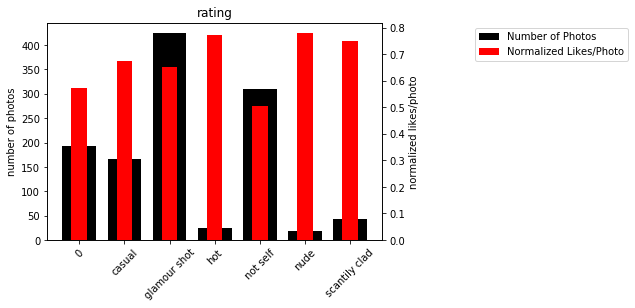

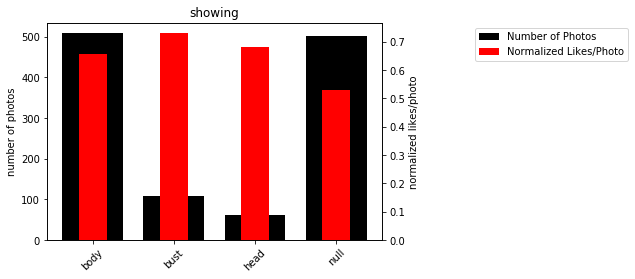

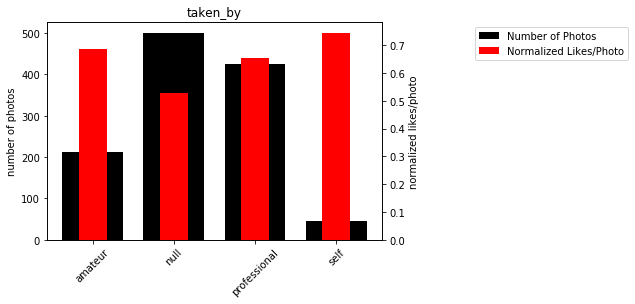

In [38]:
features = ['rating', 'showing', 'taken_by']
def bar_category(df, category):
    category_x = np.sort(df[category].unique())
    category_y = []
    category_likes = []
    cat_var = []
    for i in category_x:
        category_y.append(len(df.loc[df[category] == i]))
        category_likes.append(sum(df.loc[df[category] == i]['likes'])/category_y[-1])

#     print(category_likes)
    category_likes = np.array(category_likes)/max(category_likes)
#     print(category_likes)
    fig, ax = plt.subplots()
    plt1 = ax.bar(category_x, category_y, width=0.75, color='k')
    ax0 = ax.twinx()
    plt2 = ax0.bar(category_x, category_likes, width=0.35, color='r')
    ax.set_xticklabels(category_x, rotation=45)
    ax.set_ylabel('number of photos')
    ax0.set_ylabel('normalized likes/photo')
    plts = [plt1, plt2]
    labels = ['Number of Photos', 'Normalized Likes/Photo']
    ax.set_title(category)
    ax0.legend(plts, labels, bbox_to_anchor=[1.75, 0, 0, 1])
    print(f'{category_x[np.argmax(category_likes)]} photos get the most normalized likes per photo and {category_x[np.argmin(category_likes)]} get the least');
#     print(np.var(category_likes)/np.mean(category_likes))
    
for i in features:
    bar_category(data0, i)

To dig a little deeper we can run an ANOVA test. The function below is written as to compare all the normalized likes for labels within a feature or all the the labels except one.  If our p value is greater than 0.05 then we can say the difference betweeen normalized likes for each label is not statistically signifacant.

In the results we see incredibly small values indicating that the differences between normalized likes for each label cannot be ignored, however when the test is run omitting photos not of the user the p value shoots up by ~10^5 for all the features. In a separate notebook the test was run omitting other labels, but the p value never changed by as much. This massive difference further confirms that photos not fo the user are bringing down the overall like count. This also further evidences that as long as she posts photos of herself her normalized likes per photo is quite high.

In [33]:
def ANOVA(df, category, omit=False):
    string = 'f_oneway('
    base_filter = 'df.loc[df[category] == i]["likes"]'
    for i in np.sort(df[category].unique()):
        if(i not in ['not self', 'null'] and omit):
            string += f'df.loc[df[category] == "{i}"]["likes"], '
        elif(not omit):
            string += f'df.loc[df[category] == "{i}"]["likes"], '
    string = string[:len(string) - 2]
    string += ')'
    if(not omit):
        print(f'{eval(string)} - all labels')
    else:
        print(f'{eval(string)} - all except photos not of herself\n')

for i in features:
    print(i)
    ANOVA(data0, i)
    ANOVA(data0, i, omit=True)

# print(data0.loc[~data0['rating'].isin(['0', 'not self'])]['likes'].mean())
# print(f_oneway(data0.loc[data0['rating'] == 'hot']['likes'], data0.loc[data0['rating'] == 'casual']['likes']))

rating
F_onewayResult(statistic=90.29269747358671, pvalue=3.339779810289069e-93) - all labels
F_onewayResult(statistic=41.4683811715948, pvalue=2.5605381376244205e-38) - all except photos not of herself

showing
F_onewayResult(statistic=148.19398134528834, pvalue=1.8642000834605086e-81) - all labels
F_onewayResult(statistic=20.926146617129955, pvalue=1.5209750704162836e-09) - all except photos not of herself

taken_by
F_onewayResult(statistic=144.64173131445853, pvalue=8.942858038521886e-80) - all labels
F_onewayResult(statistic=16.321723450311485, pvalue=1.1950749585993345e-07) - all except photos not of herself



### The üî•HOTTESTüî• pic
For kicks let's see what photos match the highest liked labels for each category: nude, bust, self. There are only two images that match this combinaiton of labels and after looking at one I'd probaby throw it a like too. The photo shown below got essentially half as many likes as the other though...

photo_num   timestamp  likes  comments  \
75        1104  1568841126  10523       184   
304        875  1531264385   5618        81   

                                               caption  \
75   That Thotty girl from Euphoria Dick Sucking ma...   
304             Well-behaved women seldom make history   

                    location rating showing taken_by            datetime  \
75   Los Angeles, California   nude    bust     self 2019-09-18 21:12:06   
304       New York, New York   nude    bust     self 2018-07-10 23:13:05   

           date  year  day  hour  
75   2019-09-18  2019    2    21  
304  2018-07-10  2018    1    23

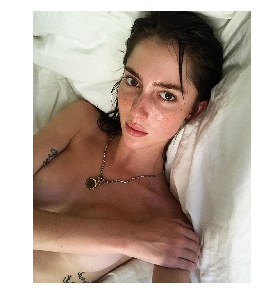

In [47]:
top_img = data.loc[(data['rating'] == 'nude') & (data['showing'] == 'bust') & (data['taken_by'] == 'self')]
display(top_img)
plot_img(875)

Well, these pics were over taken over a year apart and thus while it has lower absolute likes, it has a much higher normalzied like value of 0.82. This means that relative to other photos and her follower count at the time getting 5618 likes was a incredible amount. 

In [173]:
time_diff = top_img['timestamp'].diff()[top_img.index[1]]
print(f'{round(abs(time_diff)/60/60/24/365, 1)} years')
print(f'{round(data0.loc[top_img.index[1], "likes"], 2)} vs {round(data0.loc[top_img.index[0], "likes"], 2)}')

1.2 years
0.82 vs 0.69


### So why does it seem like hot pics get all the attention?
On Teddy's Instagram stories she complained that her modeling photos weren't getting any love. It's unlikely this belief came out of nowhere, so let's try to see if there's some other factor at play that makes the contrast more stark.

not self photos are on the rise while 0 images are being posted less
bust photos are on the rise while null images are being posted less
self photos are on the rise while null images are being posted less


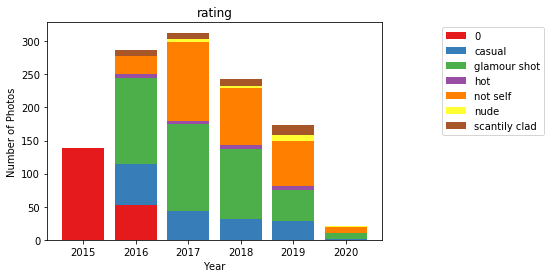

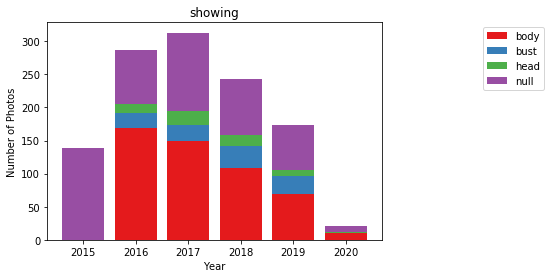

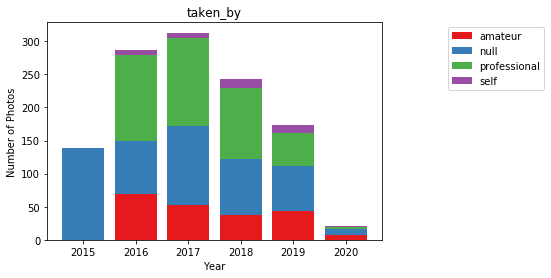

In [130]:
def plot_categories_in_time(df, category):
    cmap = 'Set1'
    plt.rcParams['image.cmap'] = cmap
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=eval(f'plt.cm.{cmap}.colors'))
    plt.figure()
    
    years = np.sort(data['year'].unique())
    categories = list(np.sort(data[category].unique()))
    category_base = np.zeros(len(years))
    category_adders = np.zeros(len(years))
    category_trend = []
    for i in categories:
        category_y = []
        for j in range(len(years)):
            subset = df.loc[(df['year'] == years[j]) & (df[category] == i)]
            category_y.append(len(subset))
#             category_y.append(subset['likes'].sum()) # unhash to chage plot to sum of normalized likes (will look nearly identical)
            category_adders[j] = category_y[-1]
        plt.bar(years, category_y, bottom=category_base)
        category_trend.append(linregress(years, category_y)[0])
        category_base += category_adders
    print(f'{categories[np.argmax(category_trend)]} photos are on the rise while {categories[np.argmin(category_trend)]} images are being posted less')
    total = []
    for i in years:
        total.append(len(df.loc[data['year'] == i])) # get y array for total photos
#         total.append(sum(df.loc[data['year'] == i]['likes'])) # get y array for total normalized likes
#     plt.plot(years, total, color='k', linewidth=2) # unhash to plot one or the other of the above totals
#     categories.append('total')
    plt.xlabel('Year')
    plt.ylabel('Number of Photos')
    plt.title(category)
    plt.legend(categories, bbox_to_anchor=[1.5, 0, 0, 1])

for i in features:
    plot_categories_in_time(data0, i)

In [123]:
glam = data0.loc[(data0['rating'] == 'glamour shot') & (data0['showing'] == 'body') & (data0['taken_by'] == 'professional')]
hot = data0.loc[data0['rating'].isin(['hot', 'scantily clad', 'nude'])]
not_self = data0.loc[data0['rating'] == 'not self']
print(f'''Glamour shots of the body by professionals are {round(len(glam)/len(data0)*100, 1)}% of all the photos Teddy posts, whereas photos rated hot, 
scantily clad, or nude combined make up only {round(len(hot)/len(data0)*100, 1)}% of her posts to date. Simlarly, the glamour photos have brought 
in {round(sum(glam['likes'])/sum(data0['likes'])*100, 1)}% of the normalized likes while hot pics brought in  {round(sum(hot['likes'])/sum(data0['likes'])*100, 1)}%.

The real killers are the photos which are not of herself which are {round(len(not_self)/len(data0)*100, 1)}% of all her content, but bring in only {round(sum(not_self['likes'])/sum(data0['likes'])*100, 1)}%
of the likes.''')

Glamour shots of the body by professionals are 28.5% of all the photos Teddy posts, whereas photos rated hot, 
scantily clad, or nude combined make up only 7.4% of her posts to date. Simlarly, the glamour photos have brought 
in 30.0% of the normalized likes while hot pics brought in  9.2%.

The real killers are the photos which are not of herself which are 26.3% of all her content, but bring in only 21.6%
of the likes.


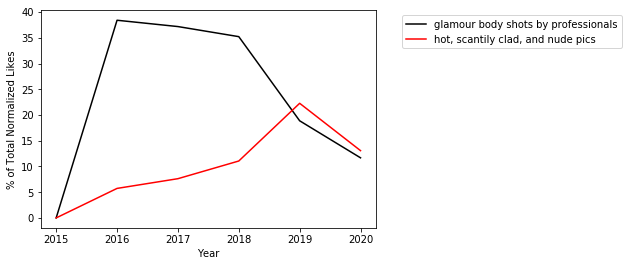

In [119]:
years = np.sort(data0['year'].unique())
glam_likes = []
hot_likes = []
not_self_likes = []
for i in years:
    glam_likes.append(data0.loc[(data0['year'] == i) & (data0['rating'] == 'glamour shot') & (data0['showing'] == 'body') & (data0['taken_by'] == 'professional')]['likes'].sum()/data0.loc[data0['year'] == i]['likes'].sum()*100)
    hot_likes.append(data0.loc[(data0['year'] == i) & (data0['rating'].isin(['hot', 'scantily clad', 'nude']))]['likes'].sum()/data0.loc[data0['year'] == i]['likes'].sum()*100)
    not_self_likes.append(data0.loc[(data0['year'] == i) & (data0['rating'] == 'not self')]['likes'].sum()/data0.loc[data0['year'] == i]['likes'].sum()*100)
plt1 = plt.plot(years, glam_likes, color='k')
plt2 = plt.plot(years, hot_likes, color='r')
# plt3 = plt.plot(years, not_self_likes)
plt.xlabel('Year')
plt.ylabel('% of Total Normalized Likes')
plt.legend(['glamour body shots by professionals', 'hot, scantily clad, and nude pics'], bbox_to_anchor=[1.75, 0, 0, 1]);

## Conclusion
yes, but no



In [231]:
top_img = data.loc[(data['rating'] == 'glamour shot') & (data['showing'] == 'body') & (data['taken_by'] == 'professional')]
print(round(len(top_img)/len(data), 3))

print(sum(top_img['likes'])/sum(data['likes']))

print(len(data.loc[data['rating'] == 'not self'])/len(data))

0.285
0.24719340011917385
0.2625318606627018


photo_num                                                 1152
timestamp                                           1577042633
likes                                                    17682
comments                                                  2209
caption      I‚Äôve been called a slut and a whore more times...
location                                        …¥·¥è “ì·¥ú·¥Ñ·¥ãs …¢…™·¥†·¥á…¥
rating                                                    nude
showing                                                   bust
taken_by                                               amateur
datetime                                   2019-12-22 19:23:53
date                                                2019-12-22
year                                                      2019
day                                                          6
hour                                                        19
Name: 24, dtype: object
photo_num                      585
timestamp               1498683588
likes

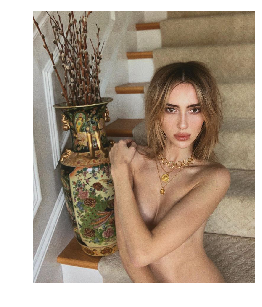

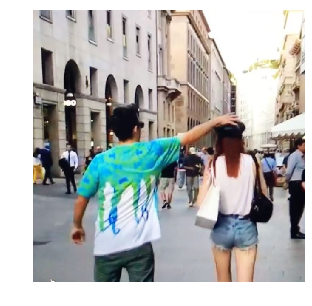

In [67]:
print(data.loc[data['likes'].idxmax, :])
plot_img(1152)
print(data0.loc[data0['likes'].idxmax, :])
plot_img(585)

photo_num                                                   37
timestamp                                           1434064217
likes                                                       53
comments                                                     3
caption      üåπüå∫HEY JUDE üå∫üåπ #PaulMcCartney #Concert #2015 #p...
location                                                  null
rating                                                       0
showing                                                   null
taken_by                                                  null
datetime                                   2015-06-11 23:10:17
date                                                2015-06-11
day                                                          3
hour                                                        23
Name: 1139, dtype: object
photo_num                                  1172
timestamp                            1582110737
likes                                 0.0279198

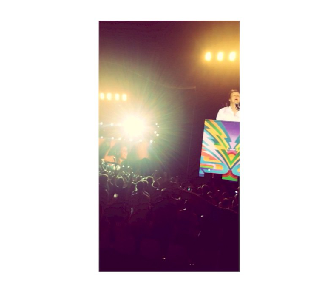

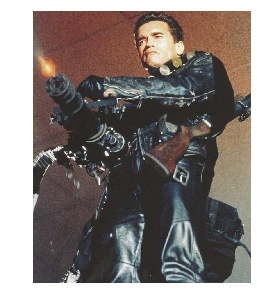

In [209]:
print(data.loc[data['likes'].idxmin, :])
plot_img(37)

no_ig_vid = data0.loc[data0['likes'] != min(data0['likes'])] # actual 0 likes if ig vid of opening to final fantasy
print(no_ig_vid.loc[no_ig_vid['likes'].idxmin, :])
plot_img(1172)

In [300]:
display(data0.loc[data0['likes'] >= 0.7].head()) # [['rating', 'showing', 'taken_by']]

photo_num   timestamp     likes  comments  \
24       1152  1577042633  0.756491  0.913261   
54       1122  1571590005  0.729885  0.692534   
70       1106  1569004988  0.735018  0.611344   
74       1102  1568395575  0.741527  0.680845   
81       1095  1567095775  0.744366  0.593289   

                                              caption  \
24  I‚Äôve been called a slut and a whore more times...   
54                                    What‚Äôs Crackin?   
70  üñ§ SAVAGE X FENTY üñ§ I told myself I wouldn‚Äôt wa...   
74  üëëPAPER MAGAZINE üëë How fucking fabulous to get ...   
81  I moved to Paris 1 year ago because I had a qu...   

                             location        rating showing      taken_by  \
24                     …¥·¥è “ì·¥ú·¥Ñ·¥ãs …¢…™·¥†·¥á…¥          nude    bust       amateur   
54          Beverly Hills, California        casual    bust       amateur   
70  Barclay Center, Brooklyn New York  glamour shot    body  professional   
74                  Buckingham Palace  glamour shot    bust  professional   
81                      Paris, France  glamour shot    body       amateur   

              datetime        date  day  hour  
24 2019-12-22 19:23:53  2019-12-22    6    19  
54 2019-10-20 16:46:45  2019-10-20    6    16  
70 2019-09-20 18:43:08  2019-09-20    4    18  
74 2019-09-13 17:26:15  2019-09-13    4    17  
81 2019-08-29 16:22:55  2019-08-29    3    16

LinregressResult(slope=-9.889226619086153e-11, intercept=0.16861077818368572, rvalue=-0.24913268277515732, pvalue=4.129589771993284e-18, stderr=1.1214981915426876e-11)


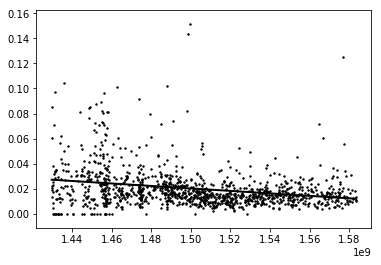

In [141]:
linreg_engagement = linregress(data['timestamp'], data['comments']/(data['likes'] + 1))
print(linreg_engagement)
plt.scatter(data['timestamp'], data['comments']/data['likes'], color='k', s=2)
plt.plot(data['timestamp'], data['timestamp']*linreg_engagement[0] + linreg_engagement[1], color='k', linewidth=2);

17682
0.6118157385168325


photo_num   timestamp  likes  comments  \
87       1089  1565885669  11357       201   

                                              caption location  rating  \
87  No lie, One time a guy offered to pay me $500 ...  Area 51  casual   

   showing taken_by            datetime        date  day  hour  
87    head     self 2019-08-15 16:14:29  2019-08-15    3    16

photo_num   timestamp     likes  comments  \
87       1089  1565885669  0.732245  0.616029   

                                              caption location  rating  \
87  No lie, One time a guy offered to pay me $500 ...  Area 51  casual   

   showing taken_by            datetime        date  day  hour  
87    head     self 2019-08-15 16:14:29  2019-08-15    3    16

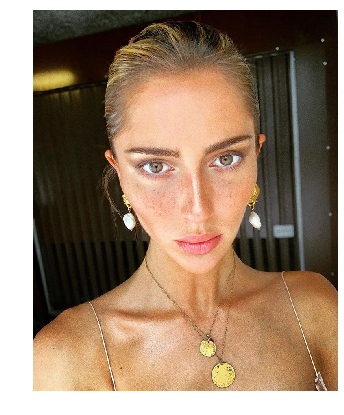

In [276]:
print(max(data['likes']))
print(data0['likes'].mean())
n = 1089
display(data.loc[data['photo_num'] == n])
display(data0.loc[data0['photo_num'] == n])
# print(data0.loc[data0.loc[data0['photo_num'] == n].index[0], 'caption'])
plot_img(n)

In [ ]:
##### print(data['comments'].idxmax())
data.loc[data['comments'].idxmin(), :]
# # print(len(data))
# print(min(data['likes']))
# TeddyQ correlation

In [117]:
data.loc[data['likes'] < 500].head()

photo_num   timestamp  likes  comments  \
208        968  1544459378    353         3   
452        724  1512403703    460         4   
540        636  1504047935    495         9   
545        631  1503358512    477         6   
555        621  1502471017    423         6   

                                          caption            location  \
208  REDKEN üñ§\n#colorgelslacquers #redken @redken                       
452          Music: Julian Winding - Disconnected  New York, New York   
540                  Drew Barrymore - Scream 1996  New York, New York   
545                     Ghost in the Shell - 1995  New York, New York   
555                                   „ÅÇ„ÅÇÂä©„Åã„Å£„Åü„ÄÅÈáëÊõúÊó•„Å†  New York, New York   

       rating showing taken_by  
208  not self                   
452         0                   
540         0                   
545         0                   
555         0

## Appendix

In [2]:
api = InstagramAPI('500daysofsingle', 'Blackmill1@')

In [3]:
api.login()

Request return 405 error!
{'message': '', 'status': 'fail'}
Login success!



True

In [6]:
api.getUserFeed('1904001441')

True

In [7]:
user_data = api.LastJson['items']

In [17]:
columns = ['photo_num', 'timestamp', 'likes', 'comments', 'caption', 'location', 'rating', 'showing', 'taken_by']
ar = np.zeros((len(user_data), len(columns)))
df = pd.DataFrame(ar, columns=columns)
for i in range(len(user_data) - 1, -1, -1):
    if(user_data[i]['taken_at'] == data.loc[data['timestamp'].idxmax(), 'timestamp']):
        counter = 0
        for j in range(i - 1, -1, -1):
            try:
                time = user_data[j]['taken_at']
            except:
                time = ''
            try:
                likes = user_data[j]['like_count']
            except:
                likes = 0
            try:
                comments = user_data[j]['comment_count'] # comments may be disabled
            except:
                comments = 0
            try:
                caption = user_data[j]['caption']['text']
            except:
                caption = ''
            try:
                location = user_data[j]['location']['name'] # location wasn't always a feature
            except:
                location = ''

            df.loc[j, :] = [0, time, likes, comments, caption, location, '', '', '']

            try:
                link = user_data[j]['image_versions2']['candidates'][0]['url']
                urllib.request.urlretrieve(link, f'/Users/XXI/Desktop/TQ_Data/TQ_{len(data) + counter}.jpg')
            except:
                try:
                    link = user_data[j]['carousel_media'][1]['image_versions2']['candidates'][0]['url']
                    urllib.request.urlretrieve(link, f'/Users/XXI/Desktop/TQ_Data/TQ_{len(data) + counter}.jpg')
                except:
                    pass
            counter += 1

df = df.loc[df['timestamp'] != 0]
df['photo_num'] = np.arange(len(data) + len(df) - 1, len(data) - 1, -1)
display(df)
df = pd.concat([data, df], sort=False)
df.sort_values(by='timestamp', inplace=True)
# df.to_csv('/Users/XXI/Desktop/TQ_Data/TQ_Data.csv', index=False)

photo_num     timestamp    likes  comments  \
0       1179  1.584212e+09   1475.0      30.0   
1       1178  1.584051e+09   4057.0      82.0   
2       1177  1.583776e+09  12418.0     220.0   

                                             caption                 location  \
0                     Cough on me bitch. I dare you.  Los Angeles, California   
1                                          Lil Teddy                            
2  Coverstory for El Pa√≠s Semanal shot by Gorka P...                    Spain   

  rating showing taken_by  
0                          
1                          
2